In [2]:
import os
import sys
import time
import random
import warnings
import collections
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, StackingRegressor, HistGradientBoostingRegressor 
# from sklearn.linear_model import Ridge, Lasso, BayesianRidge, ElasticNet
from sklearn.preprocessing import OneHotEncoder

sys.path.append('../src')
import cb_utils, cb_model_utils

sns.set(style="darkgrid")
pd.options.display.max_columns = 500

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
master_df = pd.read_parquet('./data/master_wide_v7.parquet')

### Evaluate model performance when removing group

In [22]:
d = cb_model_utils.build_mom_stddos_dem(master_df)
train, val, test =  cb_model_utils.train_val_test_split(d, return_wo_saving=True)

x,y = cb_model_utils.get_xy(train)

model = HistGradientBoostingRegressor()
model.fit(x,y)

#### Performance with group

In [25]:
cb_model_utils.get_model_performance(model, train, val)

{'train_score': 0.2163009383612321,
 'val_score': 0.13293282599596745,
 'train_mae': 5017.414501533003,
 'val_mae': 5174.910453031381}

In [18]:
cb_model_utils.get_model_performance(model, train, val)

{'train_score': 0.21646465442867568,
 'val_score': 0.14672957507357798,
 'train_mae': 5068.862251413437,
 'val_mae': 5048.2664631153075}

#### Performance with group

In [26]:
non_group_cols = [c for c in x.columns if 'is_group_' not in c]
model = HistGradientBoostingRegressor()
model.fit(x[non_group_cols], y)

HistGradientBoostingRegressor()

In [27]:
cb_model_utils.get_model_performance(model, train[non_group_cols + ['target']], val[non_group_cols + ['target']])

{'train_score': 0.2131458535265427,
 'val_score': 0.1328058887775737,
 'train_mae': 5024.981737058297,
 'val_mae': 5177.730939297613}

In [21]:
cb_model_utils.get_model_performance(model, train[non_group_cols + ['target']], val[non_group_cols + ['target']])

{'train_score': 0.2123536044488915,
 'val_score': 0.14620862807535573,
 'train_mae': 5067.343771999616,
 'val_mae': 5045.9989809332465}

#### Group in or out appears to not make much difference

### Check if period is influencing outcome

In [33]:
master_df_p30 = master_df.loc[master_df.period > 30]

In [31]:
d = cb_model_utils.build_mom_stddos_dem(master_df)
train, val, test =  cb_model_utils.train_val_test_split(d, return_wo_saving=True)

x, y = cb_model_utils.get_xy(train)

model = HistGradientBoostingRegressor()
model.fit(x,y)

cb_model_utils.get_model_performance(model, train, val)

{'train_score': 0.21263222466517495,
 'val_score': 0.16469492665172147,
 'train_mae': 5080.3216956959595,
 'val_mae': 5192.672447746689}

In [34]:
d = cb_model_utils.build_mom_stddos_dem(master_df_p30 )
train, val, test =  cb_model_utils.train_val_test_split(d, return_wo_saving=True)

x, y = cb_model_utils.get_xy(train)

model = HistGradientBoostingRegressor()
model.fit(x,y)

cb_model_utils.get_model_performance(model, train, val)

{'train_score': 0.2738726027164524,
 'val_score': 0.1264148112768364,
 'train_mae': 5600.247573910907,
 'val_mae': 5618.594089332675}

#### Initially looks worse to do fewer periods, I wonder if it's an issue with less data
Look at avg target and distribution for each period

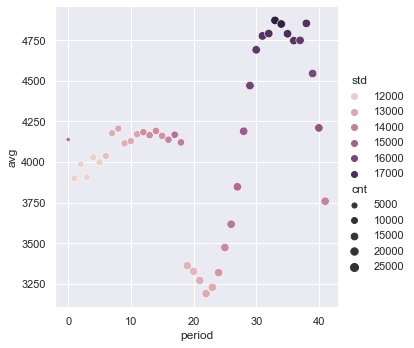

In [51]:
period_agg = master_df[['period', 'target']].groupby('period').agg(avg=('target', np.mean), std=('target', np.std), cnt=('period', np.size))
sns.relplot(data=period_agg, x='period', y='avg', size='cnt', hue='std')

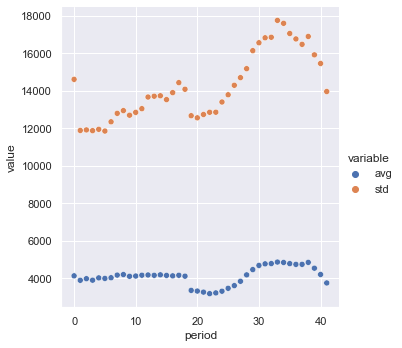

In [59]:
period_agg = master_df[['period', 'target']].groupby('period', as_index=False).agg(
    avg=('target', np.mean),
#     maxi=('target', np.max),
#     mini=('target', np.min),
    std=('target', np.std)
)
period_tall = period_agg.melt(id_vars='period')
sns.relplot(data=period_tall, x='period', y='value', hue='variable')

#### Really weird and inconsistent pattern in targets over time
Not sure what to make of it

### Add in some dx to service type ddos
#### No dx

In [84]:
d = cb_model_utils.build_mom_stddos_dem(master_df)
display(d.head())

train, val, test =  cb_model_utils.train_val_test_split(d, return_wo_saving=True)

x, y = cb_model_utils.get_xy(train)

model = HistGradientBoostingRegressor()
model.fit(x,y)

cb_model_utils.get_model_performance(model, train, val)

,ip_ddos_0,ip_ddos_1,ip_ddos_2,ip_ddos_3,ip_ddos_4,ip_ddos_5,ip_ddos_6,ip_ddos_7,ip_ddos_8,ip_ddos_9,ip_ddos_10,ip_ddos_11,er_ddos_0,er_ddos_1,er_ddos_2,er_ddos_3,er_ddos_4,er_ddos_5,er_ddos_6,er_ddos_7,er_ddos_8,er_ddos_9,er_ddos_10,er_ddos_11,out_ddos_0,out_ddos_1,out_ddos_2,out_ddos_3,out_ddos_4,out_ddos_5,out_ddos_6,out_ddos_7,out_ddos_8,out_ddos_9,out_ddos_10,out_ddos_11,snf_ddos_0,snf_ddos_1,snf_ddos_2,snf_ddos_3,snf_ddos_4,snf_ddos_5,snf_ddos_6,snf_ddos_7,snf_ddos_8,snf_ddos_9,snf_ddos_10,snf_ddos_11,icf_ddos_0,icf_ddos_1,icf_ddos_2,icf_ddos_3,icf_ddos_4,icf_ddos_5,icf_ddos_6,icf_ddos_7,icf_ddos_8,icf_ddos_9,icf_ddos_10,icf_ddos_11,hh_ddos_0,hh_ddos_1,hh_ddos_2,hh_ddos_3,hh_ddos_4,hh_ddos_5,hh_ddos_6,hh_ddos_7,hh_ddos_8,hh_ddos_9,hh_ddos_10,hh_ddos_11,amb_ddos_0,amb_ddos_1,amb_ddos_2,amb_ddos_3,amb_ddos_4,amb_ddos_5,amb_ddos_6,amb_ddos_7,amb_ddos_8,amb_ddos_9,amb_ddos_10,amb_ddos_11,hsp_ddos_0,hsp_ddos_1,hsp_ddos_2,hsp_ddos_3,hsp_ddos_4,hsp_ddos_5,hsp_ddos_6,hsp_ddos_7,hsp_ddos_8,hsp_ddos_9,hsp_ddos_10,hsp_ddos_11,pro_ddos_0,pro_ddos_1,pro_ddos_2,pro_ddos_3,pro_ddos_4,pro_ddos_5,pro_ddos_6,pro_ddos_7,pro_ddos_8,pro_ddos_9,pro_ddos_10,pro_ddos_11,spc_fac_ddos_0,spc_fac_ddos_1,spc_fac_ddos_2,spc_fac_ddos_3,spc_fac_ddos_4,spc_fac_ddos_5,spc_fac_ddos_6,spc_fac_ddos_7,spc_fac_ddos_8,spc_fac_ddos_9,spc_fac_ddos_10,spc_fac_ddos_11,dme_ddos_0,dme_ddos_1,dme_ddos_2,dme_ddos_3,dme_ddos_4,dme_ddos_5,dme_ddos_6,dme_ddos_7,dme_ddos_8,dme_ddos_9,dme_ddos_10,dme_ddos_11,cls_ddos_0,cls_ddos_1,cls_ddos_2,cls_ddos_3,cls_ddos_4,cls_ddos_5,cls_ddos_6,cls_ddos_7,cls_ddos_8,cls_ddos_9,cls_ddos_10,cls_ddos_11,hha_ddos_0,hha_ddos_1,hha_ddos_2,hha_ddos_3,hha_ddos_4,hha_ddos_5,hha_ddos_6,hha_ddos_7,hha_ddos_8,hha_ddos_9,hha_ddos_10,hha_ddos_11,is_state_TN,is_state_FL,is_state_TX,is_state_KS,is_state_IA,is_lob_1,is_lob_3,is_lob_2,is_lob_8,is_group_0.0,is_group_3.0,is_group_2.0,is_group_1.0,is_group_-1.0,is_group_5.0,is_group_6.0,is_group_4.0,is_group_8.0,is_group_14.0,is_group_16.0,is_group_7.0,is_group_11.0,is_group_15.0,is_group_20.0,is_group_12.0,is_group_13.0,is_group_9.0,is_group_21.0,is_group_18.0,is_group_10.0,is_male,age,member_id,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,6.0,1.0,0.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,1.0,0.00
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,3.0,5.0,3.0,4.0,5.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.0,2.0,253.86
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

{'train_score': 0.21495887224298582,
 'val_score': 0.13027033256565757,
 'train_mae': 5051.011608307883,
 'val_mae': 5172.653281984379}

#### All DX

In [85]:
d = cb_model_utils.build_mom_stdxddos_dem(master_df)
display(d.head())

train, val, test =  cb_model_utils.train_val_test_split(d, return_wo_saving=True, train_mems=train.member_id, val_mems=val.member_id, test_mems=test.member_id)

x, y = cb_model_utils.get_xy(train)

model = HistGradientBoostingRegressor()
model.fit(x,y)

cb_model_utils.get_model_performance(model, train, val)

,oxygen_ddos_0,oxygen_ddos_1,oxygen_ddos_2,oxygen_ddos_3,oxygen_ddos_4,oxygen_ddos_5,oxygen_ddos_6,oxygen_ddos_7,oxygen_ddos_8,oxygen_ddos_9,oxygen_ddos_10,oxygen_ddos_11,hosp_bed_ddos_0,hosp_bed_ddos_1,hosp_bed_ddos_2,hosp_bed_ddos_3,hosp_bed_ddos_4,hosp_bed_ddos_5,hosp_bed_ddos_6,hosp_bed_ddos_7,hosp_bed_ddos_8,hosp_bed_ddos_9,hosp_bed_ddos_10,hosp_bed_ddos_11,chf_ddos_0,chf_ddos_1,chf_ddos_2,chf_ddos_3,chf_ddos_4,chf_ddos_5,chf_ddos_6,chf_ddos_7,chf_ddos_8,chf_ddos_9,chf_ddos_10,chf_ddos_11,heart_ddos_0,heart_ddos_1,heart_ddos_2,heart_ddos_3,heart_ddos_4,heart_ddos_5,heart_ddos_6,heart_ddos_7,heart_ddos_8,heart_ddos_9,heart_ddos_10,heart_ddos_11,copd_ddos_0,copd_ddos_1,copd_ddos_2,copd_ddos_3,copd_ddos_4,copd_ddos_5,copd_ddos_6,copd_ddos_7,copd_ddos_8,copd_ddos_9,copd_ddos_10,copd_ddos_11,pulmonar_ddos_0,pulmonar_ddos_1,pulmonar_ddos_2,pulmonar_ddos_3,pulmonar_ddos_4,pulmonar_ddos_5,pulmonar_ddos_6,pulmonar_ddos_7,pulmonar_ddos_8,pulmonar_ddos_9,pulmonar_ddos_10,pulmonar_ddos_11,cancer_ddos_0,cancer_ddos_1,cancer_ddos_2,cancer_ddos_3,cancer_ddos_4,cancer_ddos_5,cancer_ddos_6,cancer_ddos_7,cancer_ddos_8,cancer_ddos_9,cancer_ddos_10,cancer_ddos_11,ckd_ddos_0,ckd_ddos_1,ckd_ddos_2,ckd_ddos_3,ckd_ddos_4,ckd_ddos_5,ckd_ddos_6,ckd_ddos_7,ckd_ddos_8,ckd_ddos_9,ckd_ddos_10,ckd_ddos_11,esrd_ddos_0,esrd_ddos_1,esrd_ddos_2,esrd_ddos_3,esrd_ddos_4,esrd_ddos_5,esrd_ddos_6,esrd_ddos_7,esrd_ddos_8,esrd_ddos_9,esrd_ddos_10,esrd_ddos_11,lipidy_ddos_0,lipidy_ddos_1,lipidy_ddos_2,lipidy_ddos_3,lipidy_ddos_4,lipidy_ddos_5,lipidy_ddos_6,lipidy_ddos_7,lipidy_ddos_8,lipidy_ddos_9,lipidy_ddos_10,lipidy_ddos_11,diab_ddos_0,diab_ddos_1,diab_ddos_2,diab_ddos_3,diab_ddos_4,diab_ddos_5,diab_ddos_6,diab_ddos_7,diab_ddos_8,diab_ddos_9,diab_ddos_10,diab_ddos_11,alzh_ddos_0,alzh_ddos_1,alzh_ddos_2,alzh_ddos_3,alzh_ddos_4,alzh_ddos_5,alzh_ddos_6,alzh_ddos_7,alzh_ddos_8,alzh_ddos_9,alzh_ddos_10,alzh_ddos_11,demented_ddos_0,demented_ddos_1,demented_ddos_2,demented_ddos_3,demented_ddos_4,demented_ddos_5,demented_ddos_6,demented_ddos_7,demented_ddos_8,demented_ddos_9,demented_ddos_10,demented_ddos_11,stroke_ddos_0,stroke_ddos_1,stroke_ddos_2,stroke_ddos_3,stroke_ddos_4,stroke_ddos_5,stroke_ddos_6,stroke_ddos_7,stroke_ddos_8,stroke_ddos_9,stroke_ddos_10,stroke_ddos_11,hyper_ddos_0,hyper_ddos_1,hyper_ddos_2,hyper_ddos_3,hyper_ddos_4,hyper_ddos_5,hyper_ddos_6,hyper_ddos_7,hyper_ddos_8,hyper_ddos_9,hyper_ddos_10,hyper_ddos_11,fall_ddos_0,fall_ddos_1,fall_ddos_2,fall_ddos_3,fall_ddos_4,fall_ddos_5,fall_ddos_6,fall_ddos_7,fall_ddos_8,fall_ddos_9,fall_ddos_10,fall_ddos_11,trans_ddos_0,trans_ddos_1,trans_ddos_2,trans_ddos_3,trans_ddos_4,trans_ddos_5,trans_ddos_6,trans_ddos_7,trans_ddos_8,trans_ddos_9,trans_ddos_10,trans_ddos_11,liver_ddos_0,liver_ddos_1,liver_ddos_2,liver_ddos_3,liver_ddos_4,liver_ddos_5,liver_ddos_6,liver_ddos_7,liver_ddos_8,liver_ddos_9,liver_ddos_10,liver_ddos_11,hippy_ddos_0,hippy_ddos_1,hippy_ddos_2,hippy_ddos_3,hippy_ddos_4,hippy_ddos_5,hippy_ddos_6,hippy_ddos_7,hippy_ddos_8,hippy_ddos_9,hippy_ddos_10,hippy_ddos_11,depressed_ddos_0,depressed_ddos_1,depressed_ddos_2,depressed_ddos_3,depressed_ddos_4,depressed_ddos_5,depressed_ddos_6,depressed_ddos_7,depressed_ddos_8,depressed_ddos_9,depressed_ddos_10,depressed_ddos_11,psycho_ddos_0,psycho_ddos_1,psycho_ddos_2,psycho_ddos_3,psycho_ddos_4,psycho_ddos_5,psycho_ddos_6,psycho_ddos_7,psycho_ddos_8,psycho_ddos_9,...,quad_ddos_0,quad_ddos_1,quad_ddos_2,quad_ddos_3,quad_ddos_4,quad_ddos_5,quad_ddos_6,quad_ddos_7,quad_ddos_8,quad_ddos_9,quad_ddos_10,quad_ddos_11,tbi_ddos_0,tbi_ddos_1,tbi_ddos_2,tbi_ddos_3,tbi_ddos_4,tbi_ddos_5,tbi_ddos_6,tbi_ddos_7,tbi_ddos_8,tbi_ddos_9,tbi_ddos_10,tbi_ddos_11,obese_ddos_0,obese_ddos_1,obese_ddos_2,obese_ddos_3,obese_ddos_4,obese_ddos_5,obese_ddos_6,obese_ddos_7,obese_ddos_8,obese_ddos_9,obese_ddos_10,obese_ddos_11,pressure_ulcer_ddos_0,pressure_ulcer_ddos_1,pressure_ulcer_ddos_2,pressure_ulcer_ddos_3,pressure_ulcer_ddos_4,pressure_ulcer_ddos_5,pressure_ulcer_ddos_6,pressur

{'train_score': 0.24603463303157835,
 'val_score': 0.13578174426661793,
 'train_mae': 4995.247673054297,
 'val_mae': 5139.7699264633575}

#### DX subset

In [86]:
dxes = [d for d in cb_model_utils.all_disease_cols if d in ['hyper', 'ckd', 'esrd', 'chf', 'diab', 'pressure_ulcer', 'oxygen']]
ddos_disease_cols = [f'{d}_ddos' for d in dxes]

d = cb_model_utils.build_mom_stdxddos_dem(master_df, ddos_disease_cols=ddos_disease_cols)
display(d.head())

train, val, test =  cb_model_utils.train_val_test_split(d, return_wo_saving=True, train_mems=train.member_id, val_mems=val.member_id, test_mems=test.member_id)

x, y = cb_model_utils.get_xy(train)

model = HistGradientBoostingRegressor()
model.fit(x,y)

cb_model_utils.get_model_performance(model, train, val)

,oxygen_ddos_0,oxygen_ddos_1,oxygen_ddos_2,oxygen_ddos_3,oxygen_ddos_4,oxygen_ddos_5,oxygen_ddos_6,oxygen_ddos_7,oxygen_ddos_8,oxygen_ddos_9,oxygen_ddos_10,oxygen_ddos_11,chf_ddos_0,chf_ddos_1,chf_ddos_2,chf_ddos_3,chf_ddos_4,chf_ddos_5,chf_ddos_6,chf_ddos_7,chf_ddos_8,chf_ddos_9,chf_ddos_10,chf_ddos_11,ckd_ddos_0,ckd_ddos_1,ckd_ddos_2,ckd_ddos_3,ckd_ddos_4,ckd_ddos_5,ckd_ddos_6,ckd_ddos_7,ckd_ddos_8,ckd_ddos_9,ckd_ddos_10,ckd_ddos_11,esrd_ddos_0,esrd_ddos_1,esrd_ddos_2,esrd_ddos_3,esrd_ddos_4,esrd_ddos_5,esrd_ddos_6,esrd_ddos_7,esrd_ddos_8,esrd_ddos_9,esrd_ddos_10,esrd_ddos_11,diab_ddos_0,diab_ddos_1,diab_ddos_2,diab_ddos_3,diab_ddos_4,diab_ddos_5,diab_ddos_6,diab_ddos_7,diab_ddos_8,diab_ddos_9,diab_ddos_10,diab_ddos_11,hyper_ddos_0,hyper_ddos_1,hyper_ddos_2,hyper_ddos_3,hyper_ddos_4,hyper_ddos_5,hyper_ddos_6,hyper_ddos_7,hyper_ddos_8,hyper_ddos_9,hyper_ddos_10,hyper_ddos_11,pressure_ulcer_ddos_0,pressure_ulcer_ddos_1,pressure_ulcer_ddos_2,pressure_ulcer_ddos_3,pressure_ulcer_ddos_4,pressure_ulcer_ddos_5,pressure_ulcer_ddos_6,pressure_ulcer_ddos_7,pressure_ulcer_ddos_8,pressure_ulcer_ddos_9,pressure_ulcer_ddos_10,pressure_ulcer_ddos_11,ip_ddos_0,ip_ddos_1,ip_ddos_2,ip_ddos_3,ip_ddos_4,ip_ddos_5,ip_ddos_6,ip_ddos_7,ip_ddos_8,ip_ddos_9,ip_ddos_10,ip_ddos_11,er_ddos_0,er_ddos_1,er_ddos_2,er_ddos_3,er_ddos_4,er_ddos_5,er_ddos_6,er_ddos_7,er_ddos_8,er_ddos_9,er_ddos_10,er_ddos_11,out_ddos_0,out_ddos_1,out_ddos_2,out_ddos_3,out_ddos_4,out_ddos_5,out_ddos_6,out_ddos_7,out_ddos_8,out_ddos_9,out_ddos_10,out_ddos_11,snf_ddos_0,snf_ddos_1,snf_ddos_2,snf_ddos_3,snf_ddos_4,snf_ddos_5,snf_ddos_6,snf_ddos_7,snf_ddos_8,snf_ddos_9,snf_ddos_10,snf_ddos_11,icf_ddos_0,icf_ddos_1,icf_ddos_2,icf_ddos_3,icf_ddos_4,icf_ddos_5,icf_ddos_6,icf_ddos_7,icf_ddos_8,icf_ddos_9,icf_ddos_10,icf_ddos_11,hh_ddos_0,hh_ddos_1,hh_ddos_2,hh_ddos_3,hh_ddos_4,hh_ddos_5,hh_ddos_6,hh_ddos_7,hh_ddos_8,hh_ddos_9,hh_ddos_10,hh_ddos_11,amb_ddos_0,amb_ddos_1,amb_ddos_2,amb_ddos_3,amb_ddos_4,amb_ddos_5,amb_ddos_6,amb_ddos_7,amb_ddos_8,amb_ddos_9,amb_ddos_10,amb_ddos_11,hsp_ddos_0,hsp_ddos_1,hsp_ddos_2,hsp_ddos_3,hsp_ddos_4,hsp_ddos_5,hsp_ddos_6,hsp_ddos_7,hsp_ddos_8,hsp_ddos_9,hsp_ddos_10,hsp_ddos_11,pro_ddos_0,pro_ddos_1,pro_ddos_2,pro_ddos_3,pro_ddos_4,pro_ddos_5,pro_ddos_6,pro_ddos_7,pro_ddos_8,pro_ddos_9,pro_ddos_10,pro_ddos_11,spc_fac_ddos_0,spc_fac_ddos_1,spc_fac_ddos_2,spc_fac_ddos_3,spc_fac_ddos_4,spc_fac_ddos_5,spc_fac_ddos_6,spc_fac_ddos_7,spc_fac_ddos_8,spc_fac_ddos_9,spc_fac_ddos_10,spc_fac_ddos_11,dme_ddos_0,dme_ddos_1,dme_ddos_2,dme_ddos_3,dme_ddos_4,dme_ddos_5,dme_ddos_6,dme_ddos_7,dme_ddos_8,dme_ddos_9,dme_ddos_10,dme_ddos_11,cls_ddos_0,cls_ddos_1,cls_ddos_2,cls_ddos_3,cls_ddos_4,cls_ddos_5,cls_ddos_6,cls_ddos_7,cls_ddos_8,cls_ddos_9,cls_ddos_10,cls_ddos_11,hha_ddos_0,hha_ddos_1,hha_ddos_2,hha_ddos_3,hha_ddos_4,hha_ddos_5,hha_ddos_6,hha_ddos_7,hha_ddos_8,hha_ddos_9,hha_ddos_10,hha_ddos_11,is_state_TN,is_state_FL,is_state_TX,is_state_KS,is_state_IA,is_lob_1,is_lob_3,is_lob_2,is_lob_8,is_group_0.0,is_group_3.0,is_group_2.0,is_group_1.0,is_group_-1.0,is_group_5.0,is_group_6.0,is_group_4.0,is_group_8.0,is_group_14.0,is_group_16.0,is_group_7.0,is_group_11.0,is_group_15.0,is_group_20.0,is_group_12.0,is_group_13.0,is_group_9.0,is_group_21.0,is_group_18.0,is_group_10.0,is_male,age,member_id,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

{'train_score': 0.22589784735787766,
 'val_score': 0.13609897323675846,
 'train_mae': 5014.274162705738,
 'val_mae': 5146.385351070595}

In [89]:
x, y = cb_model_utils.get_xy(train)
val_x, val_y = cb_model_utils.get_xy(val)
train_preds = model.predict(x)
val_preds = model.predict(val_x)

In [92]:
t = train.assign(pred=train_preds)

In [99]:
ten_pct_n = int(train.shape[0] * .1)
top_pred = t.nlargest(ten_pct_n, 'pred')
top_target = t.nlargest(ten_pct_n, 'target')

In [109]:
top_pred[['target', 'pred', 'member_id']].target.sum()

1458479633.0900002

In [110]:
top_target[['target', 'pred', 'member_id']].target.sum()

1458479633.09

In [100]:
top_target.target.sum() , top_pred.target.sum()

(1458479633.09, 1458479633.0900002)

In [111]:
t = val.assign(pred=val_preds)

In [112]:
ten_pct_n = int(val.shape[0] * .1)
top_pred = t.nlargest(ten_pct_n, 'pred')
top_target = t.nlargest(ten_pct_n, 'target')

In [113]:
top_pred[['target', 'pred', 'member_id']].target.sum()

252011180.57

In [114]:
top_target[['target', 'pred', 'member_id']].target.sum()

496618343.64

In [117]:
top_target.target.mean() - top_pred.target.mean()

16812.644378995123

In [ ]:
{
    'train_score': model.score(x, y),
    'val_score': model.score(val_x, val_y),
    'train_mae': np.abs(train_preds - y).mean(),
    'val_mae': np.abs(val_preds - val_y).mean()
}

In [120]:
# model.train_score_
model.validation_score_

array([-1.07022346e+08, -1.04823821e+08, -1.03003139e+08, -1.01479216e+08,
       -1.00192984e+08, -9.90761901e+07, -9.81648869e+07, -9.74166169e+07,
       -9.67411495e+07, -9.61464946e+07, -9.56657736e+07, -9.52410022e+07,
       -9.48576125e+07, -9.45198742e+07, -9.42214847e+07, -9.39246067e+07,
       -9.36804583e+07, -9.34532533e+07, -9.32686235e+07, -9.31228204e+07,
       -9.29154189e+07, -9.27678744e+07, -9.26400894e+07, -9.25482200e+07,
       -9.24356180e+07, -9.23759032e+07, -9.23124593e+07, -9.22341517e+07,
       -9.21598021e+07, -9.20882549e+07, -9.20609179e+07, -9.20334982e+07,
       -9.19737974e+07, -9.19166416e+07, -9.18544900e+07, -9.18383076e+07,
       -9.18170171e+07, -9.17992563e+07, -9.17819750e+07, -9.17690668e+07,
       -9.17264059e+07, -9.17178067e+07, -9.16916697e+07, -9.16717017e+07,
       -9.16471959e+07, -9.16408757e+07, -9.16393305e+07, -9.16259076e+07,
       -9.16043198e+07, -9.15790881e+07, -9.15668885e+07, -9.15647605e+07,
       -9.15461354e+07, -